# Qu: demo segmentation notebook

RESNET model intergration

## Set up and import

In [1]:
# Import relevant modules
from pathlib import Path

import matplotlib.pyplot as plt
from tifffile import imread
import torch
import sys
sys.path.append("..")
%config Completer.use_jedi = False
from qu.data import DataManager
from qu.models import ResnetSegmenter
from qu.models import ResnetSegmenterSettings
from qu.demo import get_demo_segmentation_dataset

## Prepare the data and the model

In [2]:
# Get the demo dataset
data_root_path = get_demo_segmentation_dataset()
print(data_root_path)

# Set the working dir
working_dir = data_root_path

/home/matt/.qu/data/demo_segmentation


In [3]:
# Notice: you can point tensorboard to ${data_root_path}.

In [4]:
# Scan for data
dataManager = DataManager()
dataManager.root_data_path = data_root_path
dataManager.scan()

True

In [5]:
# Report on the experiment type
print(f"Experiment type = {dataManager.experiment_type}")

Experiment type = ExperimentType.CLASSIFICATION


In [6]:
# Summary of found data
print(f"Found {dataManager.num_images} images.")
print(f"Found {dataManager.num_masks} masks.")
print(f"Found {dataManager.num_targets} targets (expected 0).")

Found 90 images.
Found 90 masks.
Found 0 targets (expected 0).


In [7]:
# Split images into training, validation and test set
train_image_names, train_mask_names, \
val_image_names, val_mask_names, \
test_image_names, test_mask_names = dataManager.training_split()

In [8]:
# Report split
print(f"Split: {len(train_image_names)}/{len(val_image_names)}/{len(test_image_names)}")

Split: 67/18/5


Text(0.5, 0, '0 = background, 1 = cell, 2 = border')

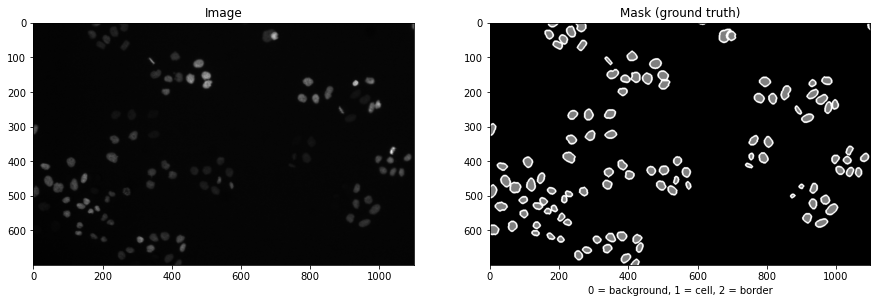

In [9]:
# Show an example pair
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15,10))
ax1.imshow(imread(train_image_names[0]), cmap='gray')
ax1.set_title("Image")
ax2.imshow(imread(train_mask_names[0]), cmap='gray')
ax2.set_title("Mask (ground truth)")
ax2.set_xlabel("0 = background, 1 = cell, 2 = border")

## Set up the Segmenter

In [10]:
# Check
print(f"Number of input channels found in image data: {dataManager.num_input_channels}")
print(f"Number of classes found in mask data: {dataManager.num_classes}")
print(f"Mask type estimated from mask data: {dataManager.mask_type}")

Number of input channels found in image data: 1
Number of classes found in mask data: 3
Mask type estimated from mask data: MaskType.TIFF_LABELS


In [12]:
# Initialize the settings
settings = ResnetSegmenterSettings()

In [13]:
# Change some settings from their default values
settings.roi_size = (512, 512)
settings.batch_sizes = (8, 1, 1, 1)
#settings.num_epochs = 10

In [14]:
# Get the settings as dictionary
settings_dict = settings.to_dict()

In [16]:
# Initialize the Segmenter passing the settings dictionary
segmenter = ResnetSegmenter(
    in_channels=dataManager.num_input_channels,
    out_channels=dataManager.num_classes,
    # **settings_dict,
    num_epochs=10,
    working_dir=working_dir
)

In [17]:
# Add the data
segmenter.set_training_data(
    train_image_names,
    train_mask_names,
    val_image_names,
    val_mask_names,
    test_image_names,
    test_mask_names
)

## Train the model

In [18]:
# Free GPU memory
torch.cuda.empty_cache()

In [ ]:
# Train the model
result = segmenter.train()

CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370117127/work/c10/cuda/CUDAFunctions.cpp:100.)


Using device 'cpu'.
--------------------------------------------------------------------------------
Epoch 1/10
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.8967
Batch 2/9: train_loss = 0.8645
Batch 3/9: train_loss = 0.8718
Batch 4/9: train_loss = 0.8588
Batch 5/9: train_loss = 0.8192
Batch 6/9: train_loss = 0.8041
Batch 7/9: train_loss = 0.7601
Batch 8/9: train_loss = 0.8120
Batch 9/9: train_loss = 0.7668
Average loss = 0.8282
--------------------------------------------------------------------------------
Epoch 2/10
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.7338
Batch 2/9: train_loss = 0.7639
Batch 3/9: train_loss = 0.8237
Batch 4/9: train_loss = 0.8457
Batch 5/9: train_loss = 0.7825
Batch 6/9: train_loss = 0.7381
Batch 7/9: train_loss = 0.7611
Batch 8/9: train_loss = 0.7705
Batch 9/9: train_loss = 0.7896
Average loss = 0.7788
--------------------------------

In [ ]:
if not result:
    print(segmenter.get_message())

## Test predict

In [ ]:
# Run prediction on the test set
result = segmenter.test_predict()

In [ ]:
if not result:
    print(segmenter.get_message())

In [ ]:
# Load one of the predicted images for comparison
filename = Path(test_image_names[0]).name.replace('train_', 'pred_')
filename = data_root_path / "tests" / filename
prediction = imread(filename)

In [ ]:
# Show an example test prediction
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15,10))
ax1.imshow(imread(test_mask_names[0]), cmap='gray')
ax1.set_title("Mask (ground truth)")
ax1.set_xlabel("0 = background, 1 = cell, 2 = border")
ax2.imshow(prediction, cmap='gray')
ax2.set_title("Prediction")
ax2.set_xlabel("0 = background, 1 = cell, 2 = border")

## Predict on new data

In [ ]:
# Get path of best model
best_model_path = segmenter.get_best_model_path()
print(best_model_path)

In [ ]:
# Just for the sake of example, predict on all images. 
# In practice, you would use brand new images here.
input_folder = Path(data_root_path) / "images"
output_folder = Path(working_dir) / "preds"

result = segmenter.predict(input_folder, output_folder, best_model_path)

In [ ]:
if not result:
    print(segmenter.get_message())

## Evaluating results visually


In [ ]:
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import numpy as np 

def compare_images(truth_img_path, pred_img_path):
    # import images
    if isinstance(truth_img_path, Path):
        truth_img_path = str(truth_img_path.resolve())
    if isinstance(pred_img_path, Path):
        pred_img_path = str(pred_img_path.resolve())
    truth_img = np.array(Image.open(truth_img_path))
    pred_img = np.array(Image.open(pred_img_path))
    # display differences
    truth_img = np.array(Image.open(truth_img_path))
     # difference in all classes
    gen_diff = truth_img != pred_img
    
    # difference for each classes
    class_list = list(np.unique(truth_img))[1:]
    print(class_list)
    fig,axs = plt.subplots(ncols=1, nrows=class_list[-1]+1, figsize=(30,35))
    for a,n in enumerate(class_list):
        t_im = truth_img.copy()
        t_im[ t_im != n ] = 0
        p_im = pred_img.copy()
        p_im[ p_im != n ] = 0
        
        axs[a].imshow(p_im != t_im)
        axs[a].set_title(f" difference in class {n}" )
        axs[a].set_axis_off()
    axs[class_list[-1]].imshow(gen_diff)
    axs[class_list[-1]].set_title("overall difference")
    axs[class_list[-1]].set_axis_off()
    pass

In [ ]:
true_mask = input_folder.parent / "masks" / "mask_t000.tif"
pred_mask = output_folder / "pred_train_t000.tif"
compare_images(true_mask, pred_mask)

In [ ]:
true_mask = input_folder.parent / "masks" / "mask_t002.tif"
pred_mask = output_folder / "pred_train_t002.tif"
compare_images(true_mask, pred_mask)

In [ ]:
true_mask = input_folder.parent / "masks" / "mask_t005.tif"
pred_mask = output_folder / "pred_train_t005.tif"
compare_images(true_mask, pred_mask)

In [ ]:
true_mask = input_folder.parent / "masks" / "mask_t010.tif"
pred_mask = output_folder / "pred_train_t010.tif"
compare_images(true_mask, pred_mask)